In [1]:
import os

import torch

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import quad_scan_lattice
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_quad_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms.yaml'), 
                      p0c = 10.0e6,
                      save_as = os.path.join('data', 'gt_beam.pt'))

ground truth distribution saved at data/gt_beam.pt


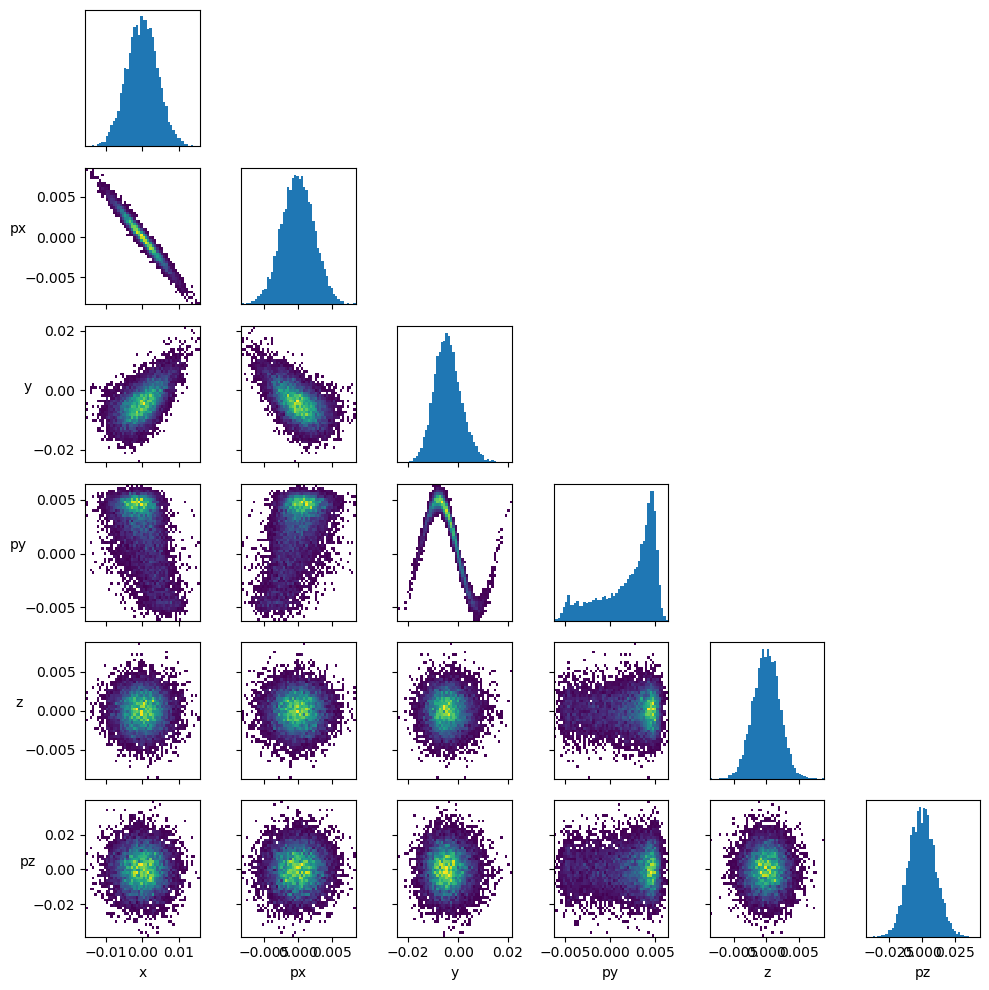

In [4]:
# plot synthetic ground truth beam projections 
plot_projections(gt_beam.data.numpy(),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

In [5]:
# diagnostic beamline:
lattice = quad_scan_lattice()

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/home/jp/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [6]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))

dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'


image size = 60 x 60 mm
test samples boxed in orange


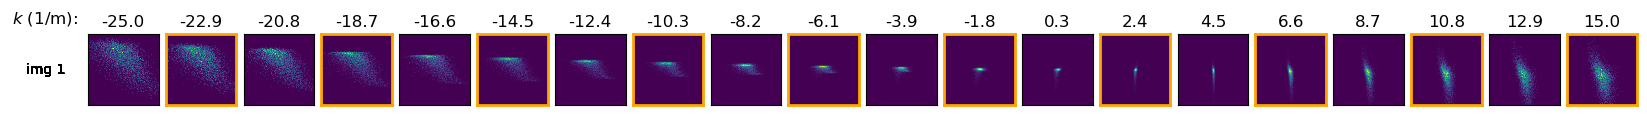

In [7]:
# plot generated datasets
plot_scan_data(train_dset, test_dset, bins)

In [8]:
# training
pred_beam = train_quad_scan(train_dset, lattice, screen, n_epochs=500, device='cuda')

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4849324., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1108421., device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1079297.3750, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1121905.1250, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1059406.8750, device='cuda:0', grad_fn=<MulBackward0>)


In [9]:
# predicted screens:
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 60 x 60 mm
test samples boxed in orange


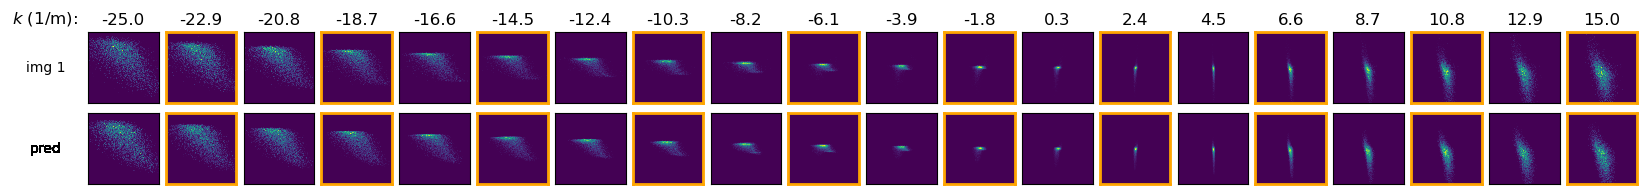

In [10]:
# compare predicted screens with data
plot_predicted_screens(pred_dset, train_dset, test_dset, bins)

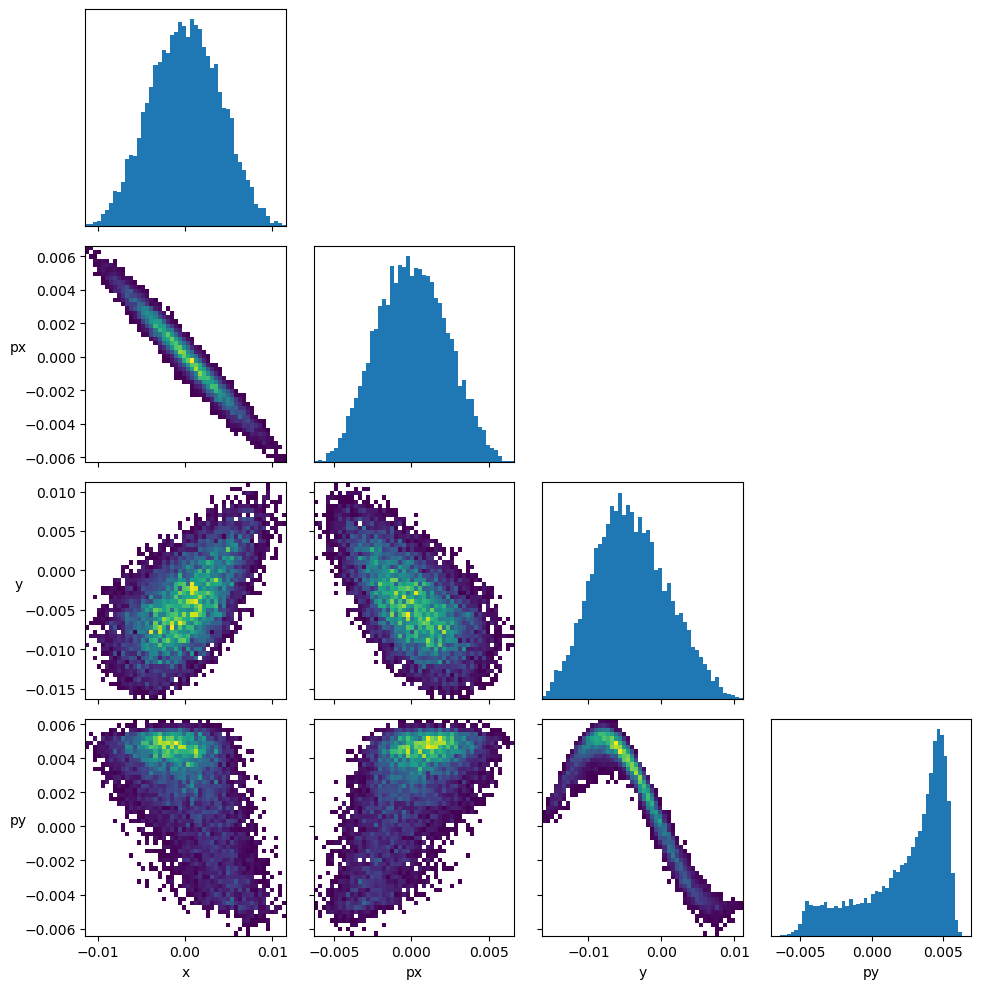

In [11]:
# reconstructed beam projections: 
plot_projections(pred_beam.data.detach().cpu().numpy()[:,:4],
                 labels=['x', 'px', 'y', 'py'],
                 bins=50,
                 background=False)

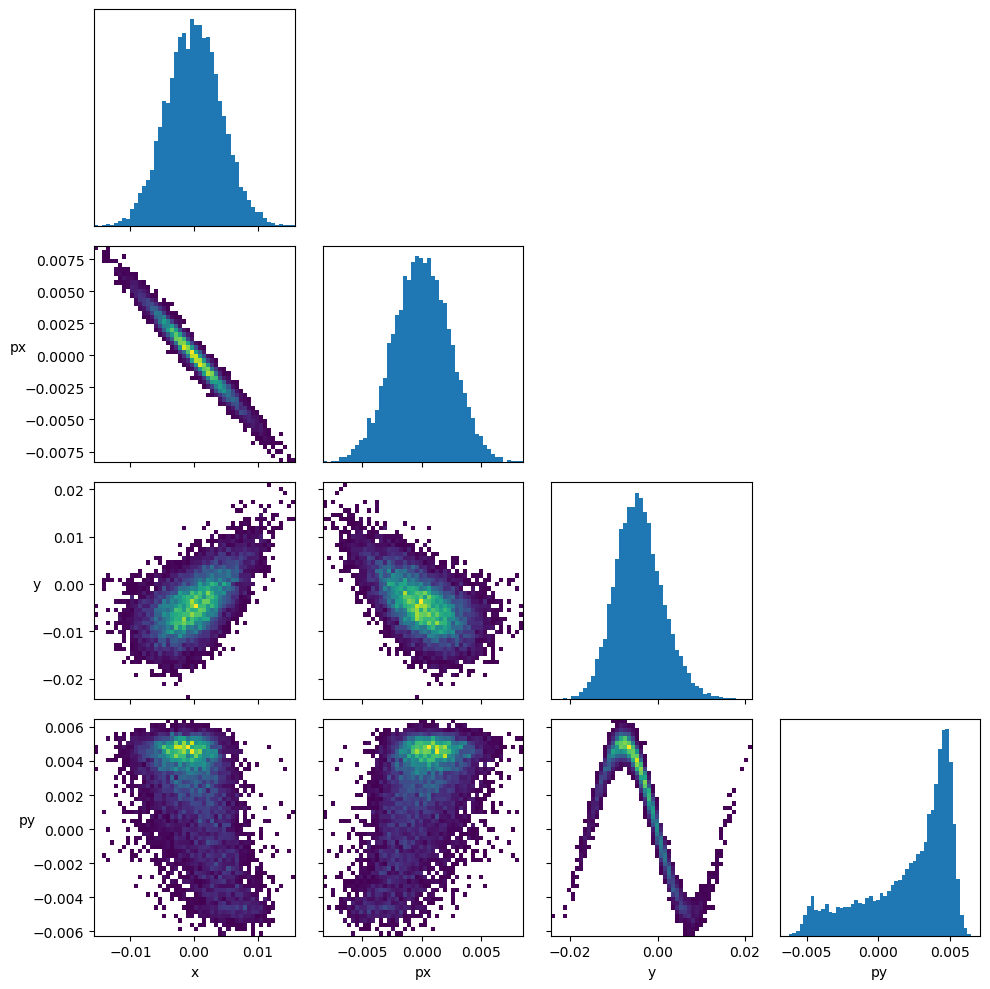

In [12]:
# ground truth beam projections:
plot_projections(gt_beam.data.numpy()[:,:4],
                 labels=['x', 'px', 'y', 'py'],
                 bins=50,
                 background=False)